In [1]:
import pickle
import flax.jax_utils
import numpy as np
import jax
import jax.tree_util as jtr
import jax.numpy as jp
import flax, optax

In [2]:
cd ../../

/home/user/PycharmProjects/tmp/BERTAP_v2


/home/user/anaconda3/envs/jax/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
from src.models.vae import VQVAE
from src.common.configs import TotalConfigs, DatasetConfig, ModelConfig, TrainConfig
from src.datasets import AntDataLoader, AntNormalizer, make_env
from src.utils.train_state import TrainState
from src.utils.ant_viz import GoalReachingAnt
from src.utils.logging_utils import Logger, compare_recons
from src.utils.context import make_rngs, save_state, load_params
from src.scripts.vae_prepare import prepare_config_dataset
from src.scripts.batch_samplers import vae_batch_sampler

/home/user/anaconda3/envs/jax/lib/python3.11/site-packages/Cython/Distutils/old_build_ext.py:15: DeprecationWarning: dep_util is Deprecated. Use functions from setuptools instead.
  from distutils.dep_util import newer, newer_group
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
No module named 'flow'
/home/user/anaconda3/envs/jax/lib/python3.11/site-packages/glfw/__init__.py:914: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
No module named 'carla'
pybullet build time: Nov 28 2023 23:48:36
/home/user/anaconda3/envs/jax/lib/python3.11/site-packages/pybullet_envs/env_bases.py:8: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version
/home/user/anaconda3/envs/jax/lib/python3.11/site-packages/pkg_resources/__init__.

In [13]:
from pathlib import Path
path = Path("./save/BERTAP_VAE_MAZE-0710-1442").absolute()
path.exists()

True

In [14]:
configs = TotalConfigs.load_from_txt(path)

In [15]:
model_def = VQVAE
env_name = configs.data_config.env_name
seq_len = configs.data_config.seq_len
latent_step = configs.model_config.latent_step
batch_size = configs.train_config.batch_size
n_epochs = configs.train_config.n_epochs

In [16]:
from src.utils.ant_viz import GoalReachingMaze
loader_size = 1000

structure = {"emb_dim": 256,
            "n_heads": 4,
            "n_layers": 3,
            "ff_dim": 256 * 4,
            "causal": True,
            "traj_emb_dim": 256,
            "n_traj_tokens": 360}
    
kwargs = {
    "model": {"ma_update": False, **structure},
    "dataset": {"goal_conditioned": True, "hierarchical_goal": False, "p_true_goal": 1.0, "p_sub_goal": 0.0},
    "train": {"exp_name": "BERTAP_VAE_MAZE"},
    "loader_size": loader_size
}

dataloader, _ = prepare_config_dataset(env_name, seq_len, latent_step, batch_size, n_epochs, **kwargs)
render_env = GoalReachingMaze(env_name)

sample_batch_fn, (normalizer, splits) = vae_batch_sampler(dataloader, batch_size, 
                                                            normalize=True, hierarchical_goal=configs.data_config.hierarchical_goal)

Loading dataset...


load datafile: 100%|██████████| 8/8 [00:00<00:00,  9.06it/s]


------------[Fixing reward for Maze2D]------------
----------[Fixing last goal for Maze2D]-----------
-----------[Transposing xy for Maze2D]------------
------------[Fixing reward for Maze2D]------------


In [17]:
eval_starts = np.arange(4) * dataloader.seq_len + dataloader.terminal_ids[21] + 1
eval_batch = sample_batch_fn(starts=eval_starts, pmap=False)

In [18]:
params = load_params(path)

In [19]:
rng = jax.random.PRNGKey(0)
rng_names = ('vq', 'dropout')
model = VQVAE(configs.model_config)
out, info = model.apply(params, **eval_batch, train=False, rngs=make_rngs(rng, rng_names))

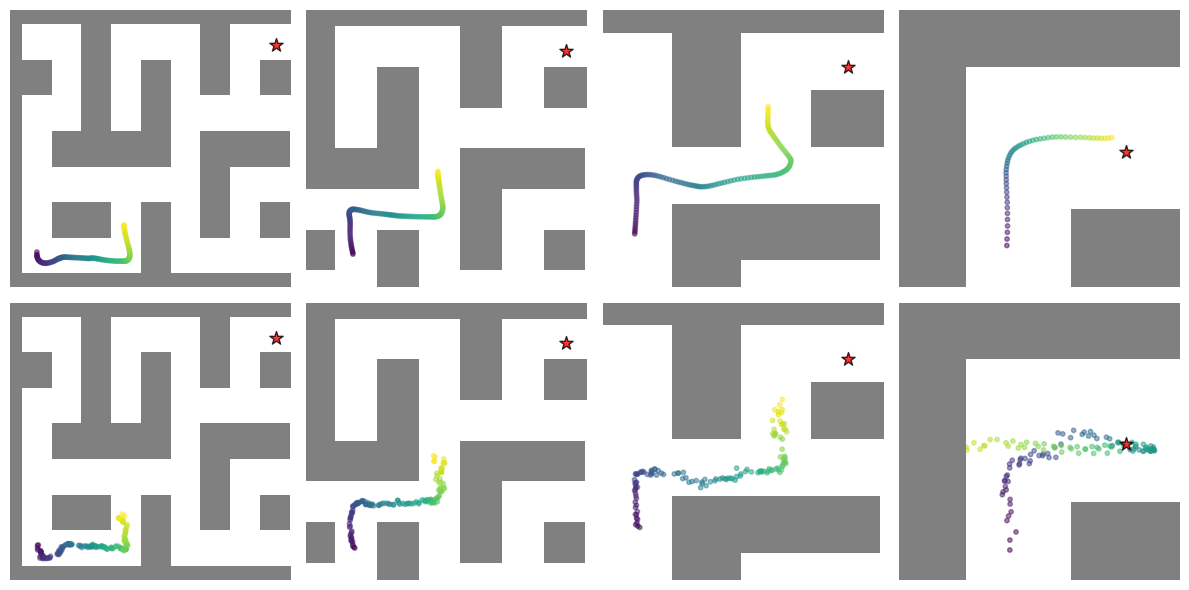

In [20]:
denorm_keys = ("goals", "observations", "actions")

compare_recons(
    logger=None,
    env=render_env,
    origs=normalizer.denormalize_concat(jax.device_get(eval_batch['traj_seq']), keys=denorm_keys, splits=splits),
    recons=normalizer.denormalize_concat(jax.device_get(out), keys=denorm_keys, splits=splits),
    goal_dim=configs.model_config.goal_dim,
    global_step=0,
    goal_conditioned=configs.model_config.goal_conditional,
    visualize=True
)